In [133]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel


import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
sys.path.append('../src')
import seis_feature
#from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os


from utils import apply_cosine_taper
from utils import butterworth_filter
from utils import plot_confusion_matrix
from utils import plot_classification_report

import pickle
from zenodo_get import zenodo_get

from pathlib import Path

In [283]:
## specify a filename 
filename = 'P_50_100_F_1_10_50'

In [284]:
if filename == 'P_10_30_F_1_15_50':
    doi = '10.5281/zenodo.12747189'
    
elif filename == 'P_10_30_F_1_10_50':
    doi = '10.5281/zenodo.13294736'
    
elif filename == 'P_10_30_F_05_15_50':
    doi = '10.5281/zenodo.13294778'
    
    

    
elif filename == 'P_10_100_F_1_10_50':
    doi = '10.5281/zenodo.12747222'
    
elif filename == 'P_10_100_F_05_15_50':
    doi = '10.5281/zenodo.13294804'
    
    
elif filename == 'P_50_100_F_1_10_50':
    doi = '10.5281/zenodo.12747234'

elif filename == 'P_50_100_F_05_15_50':
    doi = '10.5281/zenodo.13294827'
    
## This is going to download all the feature files in current directory. Make sure we delete them after storing
files = zenodo_get([doi])

Title: Physical and Tsfel Features for 150s waveforms (Updated 15 July, 2024)
Keywords: 
Publication date: 2024-07-15
DOI: 10.5281/zenodo.12747234
Total size: 1655.9 MB

Link: https://zenodo.org/record/12747234/files/tsfel_features_explosion_P_50_100_F_1_10_50_part_1.csv   size: 96.7 MB
tsfel_features_explosion_P_50_100_F_1_10_50_part_1.csv is already downloaded correctly.

Link: https://zenodo.org/record/12747234/files/physical_features_explosion_P_50_100_F_1_10_50_part_1.csv   size: 11.6 MB
physical_features_explosion_P_50_100_F_1_10_50_part_1.csv is already downloaded correctly.

Link: https://zenodo.org/record/12747234/files/tsfel_features_earthquake_P_50_100_F_1_10_50_part_3.csv   size: 301.1 MB
tsfel_features_earthquake_P_50_100_F_1_10_50_part_3.csv is already downloaded correctly.

Link: https://zenodo.org/record/12747234/files/physical_features_surface event_P_50_100_F_1_10_50_part_1.csv   size: 6.6 MB
physical_features_surface event_P_50_100_F_1_10_50_part_1.csv is already dow

## Loading tsfel features

In [285]:
# Define file paths
base_path = Path(".")  # Modify if needed

# Load physical features for surface events, thunder, and sonic booms
features_exotic_tsfel = pd.read_csv(base_path / f'tsfel_features_surface event_{filename}_part_1.csv')

# Group data by source type for better scalability
grouped_features = {source: df for source, df in features_exotic_tsfel.groupby('source')}

# Extract specific categories
features_surface_tsfel = grouped_features.get('surface event', pd.DataFrame())
features_sonic_tsfel = grouped_features.get('sonic', pd.DataFrame())
features_thunder_tsfel = grouped_features.get('thunder', pd.DataFrame())

# Load other event features
features_noise_tsfel = pd.read_csv(base_path / f'tsfel_features_noise_{filename}_part_1.csv')
features_explosion_tsfel = pd.read_csv(base_path / f'tsfel_features_explosion_{filename}_part_1.csv')

# Load and concatenate earthquake features efficiently
earthquake_files = [f'tsfel_features_earthquake_{filename}_part_{i}.csv' for i in range(1, 5)]
features_earthquake_tsfel = pd.concat([pd.read_csv(base_path / file) for file in earthquake_files], ignore_index=True)


In [286]:
print(f'No. of tsfel features: {features_exotic_tsfel.shape[1]-2}')

No. of tsfel features: 390


## Merging metadata information with the events 

In [287]:
# extracting the stored data
comcat_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5",'r')
exotic_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5",'r')
noise_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5",'r')


# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")



# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']



# extracting the index 
ind_exp = features_explosion_tsfel['serial_no'].values
ind_eq = features_earthquake_tsfel['serial_no'].values
ind_no = features_noise_tsfel['serial_no'].values
ind_su = features_surface_tsfel['serial_no'].values


exp_df = cat_exp.iloc[ind_exp]
exp_df.reset_index(drop = True, inplace = True)
exp_df['serial_no'] = ind_exp
features_explosion_tsfel['event_id'] = exp_df['event_id'].values
features_explosion_tsfel['new_event_id'] = exp_df['event_id']+'_'+exp_df['station_network_code']+'.'+exp_df['station_code']
features_explosion_tsfel['trace_start_time'] = exp_df['trace_start_time']

eq_df = cat_eq.iloc[ind_eq]
eq_df.reset_index(drop = True, inplace = True)
eq_df['serial_no'] = ind_eq
features_earthquake_tsfel['event_id'] = eq_df['event_id']
features_earthquake_tsfel['new_event_id'] = eq_df['event_id']+'_'+eq_df['station_network_code']+'.'+eq_df['station_code']
features_earthquake_tsfel['trace_start_time'] = eq_df['trace_start_time']


su_df = cat_su.iloc[ind_su]
su_df.reset_index(drop = True, inplace = True)
su_df['serial_no'] = ind_su
features_surface_tsfel['event_id'] = su_df['event_id']
features_surface_tsfel['new_event_id'] = su_df['event_id']+'_'+su_df['station_network_code']+'.'+su_df['station_code']
features_surface_tsfel['trace_start_time'] = su_df['trace_start_time']


no_df = cat_no.iloc[ind_no]
no_df.reset_index(drop = True, inplace = True)
no_df['serial_no'] = ind_no
features_noise_tsfel['event_id'] = no_df['trace_start_time']+'_noise'
features_noise_tsfel['new_event_id'] = no_df['trace_start_time']+'_noise_'+no_df['station_network_code']+'.'+no_df['station_code']
features_noise_tsfel['trace_start_time'] = no_df['trace_start_time']

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## Deleting the downloaded files to clean up the directory

In [125]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)

## Loading the features of new surface events

In [288]:
## first we would like to remove the common test dataset based on the ids
save_path = '../data'
common_test_ids = np.load(f"{save_path}/common_test_data_id.npy", allow_pickle = True)


In [289]:
features_surface_new = pd.read_csv('../extracted_features/tsfel_features_new_surface event_'+filename+'_part_1.csv', index_col = 0)

# randomly assigning the event ids to surface events. 
features_surface_new['serial_no'] = np.arange(len(features_surface_new))

# assigning a source. 
features_surface_new['source'] = ['surface event']*len(features_surface_new)

## trying to assign a date time. 
features_surface_new['event_id'] = [features_surface_new['new_event_id'].values[i].split('_')[0] for i in range(len(features_surface_new))]

stored_su_df = pd.read_csv('../data/additional_surface_events_good_snr.csv')
event_trace_map = stored_su_df.set_index('event_id')['trace_start_time'].to_dict()

# Assign trace_start_time using map() instead of looping
features_surface_new['trace_start_time'] = features_surface_new['event_id'].map(event_trace_map)


# rearranging the columns
features_new_surface_tsfel = features_surface_new.loc[:,features_earthquake_tsfel.columns]

## Merging all the features

In [290]:
features_all = pd.concat([features_surface_tsfel, features_noise_tsfel, features_explosion_tsfel, features_earthquake_tsfel, features_new_surface_tsfel])
features_all = features_all.drop(['Unnamed: 0'], axis = 1, errors = 'ignore')
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]-2} features')

So we have 247058 events and each event have 393 features


## Removing the test events from these and saving

In [291]:
test_features = features_all[features_all['new_event_id'].isin(common_test_ids)]
test_features.to_csv('../data/test_tsfel_features_'+filename+'.csv', index = False)

In [292]:
train_features = features_all[~features_all['new_event_id'].isin(common_test_ids)]
train_features

,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,0_FFT mean coefficient_38,0_FFT mean coefficient_39,0_FFT mean coefficient_40,0_FFT mean coefficient_41,0_FFT mean coefficient_42,0_FFT mean coefficient_43,0_FFT mean coefficient_44,0_FFT mean coefficient_45,0_FFT mean coefficient_46,0_FFT mean coefficient_47,0_FFT mean coefficient_48,0_FFT mean coefficient_49,0_FFT mean coefficient_50,0_FFT mean coefficient_51,0_FFT mean coefficient_52,0_FFT mean coefficient_53,0_FFT mean coefficient_54,0_FFT mean coefficient_55,0_FFT mean coefficient_56,0_FFT mean coefficient_57,0_FFT mean coefficient_58,0_FFT mean coefficient_59,0_FFT mean coefficient_60,0_FFT mean coefficient_61,0_FFT mean coefficient_62,0_FFT mean coefficient_63,0_FFT mean coefficient_64,0_FFT mean coefficient_65,0_FFT mean coefficient_66,0_FFT mean coefficient_67,0_FFT mean coefficient_68,0_FFT mean coefficient_69,0_FFT mean coefficient_70,0_FFT mean coefficient_71,0_FFT mean coefficient_72,0_FFT mean coefficient_73,0_FFT mean coefficient_74,0_FFT mean coefficient_75,0_FFT mean coefficient_76,0_FFT mean coefficient_77,0_FFT mean coefficient_78,0_FFT mean coefficient_79,0_FFT mean coefficient_80,0_FFT mean coefficient_81,0_FFT mean coefficient_82,0_FFT mean coefficient_83,0_FFT mean coefficient_84,0_FFT mean coefficient_85,0_FFT mean coefficient_86,0_FFT mean coefficient_87,0_FFT mean coefficient_88,0_FFT mean coefficient_89,0_FFT mean coefficient_90,0_FFT mean coefficient_91,0_FFT mean coefficient_92,0_FFT mean coefficient_93,0_FFT mean coefficient_94,0_FFT mean coefficient_95,0_FFT mean coefficient_96,0_FFT mean coefficient_97,0_FFT mean coefficient_98,0_FFT mean coefficient_99,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_108,0_FFT mean coefficient_109,0_FFT mean coefficient_110,0_FFT mean coefficient_111,0_FFT mean coefficient_112,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_115,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_119,0_FFT mean coefficient_120,0_FFT mean coefficient_121,0_FFT mean coefficient_122,0_FFT mean coefficient_123,0_FFT mean coefficient_124,0_FFT mean coefficient_125,0_FFT mean coefficient_126,0_FFT mean coefficient_127,0_FFT mean coefficient_128,0_FFT mean coefficient_129,0_FFT mean coefficient_130,0_FFT mean coefficient_131,0_FFT mean coefficient_132,0_FFT mean coefficient_133,0_FFT mean coefficient_134,0_FFT mean coefficient_135,0_FFT mean coefficient_136,0_FFT mean coefficient_137,0_FFT mean coefficient_138,0_FFT mean coefficient_139,0_FFT mean coefficient_140,0_FFT mean coefficient_141,0_FFT mean coefficient_142,0_FFT mean coefficient_143,0_FFT mean coefficient_144,0_FFT mean coefficient_145,0_FFT mean coefficient_146,0_FFT mean coefficient_147,0_FFT mean coefficient_148,0_FFT mean coefficient_149,0_FFT mean coefficient_150,0_FFT mean coefficient_151,0_FFT

## Adding the manual features

In [293]:
# new_exp contains the features and the corresponding metadata information. 
datetimes = train_features['trace_start_time'].values

hour_of_day = []
days_of_week = []
month_of_year = []
for dt_str in tqdm(datetimes):
        
    # Parse the datetime string
        dt = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        hod = dt.hour - 8.  # converting to local time. 
        moy = dt.month
        
        
        days_of_week.append(dt.weekday())
        hour_of_day.append(hod)
        month_of_year.append(moy)
        
train_features['hour_of_day'] = hour_of_day
train_features['day_of_week'] = days_of_week
train_features['month_of_year'] = month_of_year


100%|██████████| 238869/238869 [00:02<00:00, 90075.75it/s] 
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## Preprocessing the input features

## 1. Removing highly correlated features
Highly correlated features carry redundant information. This redundancy does not add any new information to the model but can lead to overfitting. Overfitting occurs when the model learns the noise in the training data rather than the actual signal, which reduces its generalizability to new data. So first, we will identify the features that are highly correlated to each other (cc > 0.95) and only select one of these features.


### How it works?
We will compute correlated features by computing absolute pearson correlation coefficient. Then it will select only the upper triangle of the matrix and then it is going to iterate through each column and if it finds any value greater than threshold, it will consider that as a correlated feature. Doing it this way ensures that only one of the feature drops and not both.

For more information check this out! -  
https://tsfel.readthedocs.io/en/latest/_modules/tsfel/utils/signal_processing.html#correlated_features

In [294]:
## visualising the correlated features and correlation coefficient
corr_matrix = features_all.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlated_features = [(column, row, upper.loc[row, column]) 
                               for column in upper.columns 
                               for row in upper.index 
                               if upper.loc[row, column] > 0.95]
correlated_df = pd.DataFrame(correlated_features, columns=['Feature 1', 'Feature 2', 'Correlation Coefficient'])

# Set the display option to show all rows
pd.set_option('display.max_rows', 60)

correlated_df

,Feature 1,Feature 2,Correlation Coefficient
0,0_FFT mean coefficient_2,0_FFT mean coefficient_1,0.957512
1,0_FFT mean coefficient_3,0_FFT mean coefficient_2,0.986386
2,0_FFT mean coefficient_4,0_FFT mean coefficient_2,0.958953
3,0_FFT mean coefficient_4,0_FFT mean coefficient_3,0.985929
4,0_FFT mean coefficient_5,0_FFT mean coefficient_4,0.967352
...,...,...,...
433,0_Total energy,0_Standard deviation,0.978001
434,0_Total energy,0_Variance,1.000000
435,0_Total energy,0_Absolute energy,1.000000
436,0_Total energy,0_Area under the curve,0.973344


In [295]:
serial_nos = train_features['serial_no'].values
features_all = train_features.drop(['Unnamed: 0_x','Unnamed: 0_y', 'source_x', 'serial_no'], axis = 1, errors = 'ignore')
features_all.rename(columns={'source_y': 'source'}, inplace=True)
corr_features = tsfel.correlated_features(features_all.iloc[:, 1:int(np.where(features_all.columns == 'source')[0])])

features_all.drop(corr_features, axis=1, inplace=True)
features_all['serial_no'] = serial_nos
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 238869 events and each event have 286 features


## 2. Dropping all the columns that contains infinity or nan values for any event. 
Many statistical operations, such as calculating means, variances, and covariances, do not work properly with NaN or infinity values. This can lead to incorrect parameter estimates and unreliable statistical inferences.

In [296]:
# Identify columns with NaN values
nan_columns = features_all.columns[features_all.isnull().any()].tolist()
print("Columns with NaN values:", nan_columns)

# Identify columns with infinity values
inf_columns = features_all.columns[(features_all == np.inf).any() | (features_all == -np.inf).any()].tolist()
print("Columns with infinity values:", inf_columns)

# Dropping the columns that contain NaNs
features_all = features_all.dropna(axis=1)

# Dropping the rows that contain NaNs
features_all = features_all.dropna()

# Dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()

# Dropping sonic boom and thunder events
features_all = features_all[features_all['source'] != 'sonic']
features_all = features_all[features_all['source'] != 'thunder']

print(f'So we have {features_all.shape[0]} events and each event has {features_all.shape[1]} features')

Columns with NaN values: []
Columns with infinity values: []
So we have 238869 events and each event has 286 features


## 3. Removing the features that have the same values for all the features. 
It is important to remove such features since they are not actually contributing in anything but are unnecessarily increasing the computational time. 

In [297]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index.values

print(single_value_columns)

# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


['0_ECDF_2' '0_ECDF_5' '0_ECDF_8' '0_ECDF Percentile Count_0'
 '0_ECDF Percentile Count_1' '0_Entropy']
So we have 238869 events and each event have 280 features


## 4. Removing the outliers based on z-score
Only retaining those events that have the values of all their features lying with 4 times of standard deviations for each features. 

In [298]:
df = features_all.drop(['serial_no', 'source','event_id','new_event_id','trace_start_time'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 10

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(f'So we have {outliers_removed_df.shape[0]} events and each event have {outliers_removed_df.shape[1]} features')


So we have 226087 events and each event have 280 features


## Standardizing the features

In [299]:
## defining the global variables X and y
X = outliers_removed_df.drop(['serial_no','source','event_id','new_event_id','trace_start_time'], axis = 1)
y = outliers_removed_df['source']


# Initialize the StandardScaler
scaler = StandardScaler()



# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(X)


# Access the mean and standard deviation for each feature
means = scaler.mean_
std_devs = scaler.scale_

# Create a DataFrame to display the means and standard deviations
scaler_params = pd.DataFrame({'Feature': X.columns, 'Mean': means, 'Std Dev': std_devs})
print(scaler_params)



# Create a new DataFrame with scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)


## We are not standardizing at this stage. We will rather wait when the outlier are removed, then we will
## standardize and save the standard scaler parameters. 
#X_scaled = X

X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = outliers_removed_df['source'].values
X_scaled['new_event_id'] = outliers_removed_df['new_event_id'].values

                      Feature          Mean       Std Dev
0    0_FFT mean coefficient_0  1.473657e-05  3.105649e-05
1    0_FFT mean coefficient_1  5.065769e-07  1.227500e-06
2    0_FFT mean coefficient_7  1.107387e-04  4.615377e-04
3    0_FFT mean coefficient_8  3.607969e-04  1.463975e-03
4    0_FFT mean coefficient_9  1.017575e-03  3.784742e-03
..                        ...           ...           ...
270                   0_Slope  2.693334e-13  1.654876e-10
271      0_Zero crossing rate  1.328178e+03  3.447211e+02
272               hour_of_day  3.730387e+00  7.005994e+00
273               day_of_week  2.959440e+00  1.986727e+00
274             month_of_year  6.615971e+00  3.303123e+00

[275 rows x 3 columns]


In [300]:
X_scaled

,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,0_FFT mean coefficient_38,0_FFT mean coefficient_39,0_FFT mean coefficient_40,0_FFT mean coefficient_41,0_FFT mean coefficient_42,0_FFT mean coefficient_43,0_FFT mean coefficient_44,0_FFT mean coefficient_45,0_FFT mean coefficient_46,0_FFT mean coefficient_47,0_FFT mean coefficient_48,0_FFT mean coefficient_49,0_FFT mean coefficient_50,0_FFT mean coefficient_51,0_FFT mean coefficient_52,0_FFT mean coefficient_53,0_FFT mean coefficient_54,0_FFT mean coefficient_55,0_FFT mean coefficient_56,0_FFT mean coefficient_57,0_FFT mean coefficient_58,0_FFT mean coefficient_59,0_FFT mean coefficient_60,0_FFT mean coefficient_61,0_FFT mean coefficient_62,0_FFT mean coefficient_63,0_FFT mean coefficient_64,0_FFT mean coefficient_65,0_FFT mean coefficient_66,0_FFT mean coefficient_67,0_FFT mean coefficient_68,0_FFT mean coefficient_69,0_FFT mean coefficient_70,0_FFT mean coefficient_71,0_FFT mean coefficient_72,0_FFT mean coefficient_73,0_FFT mean coefficient_74,0_FFT mean coefficient_75,0_FFT mean coefficient_76,0_FFT mean coefficient_77,0_FFT mean coefficient_78,0_FFT mean coefficient_79,0_FFT mean coefficient_80,0_FFT mean coefficient_81,0_FFT mean coefficient_82,0_FFT mean coefficient_83,0_FFT mean coefficient_84,0_FFT mean coefficient_85,0_FFT mean coefficient_86,0_FFT mean coefficient_87,0_FFT mean coefficient_88,0_FFT mean coefficient_89,0_FFT mean coefficient_90,0_FFT mean coefficient_91,0_FFT mean coefficient_92,0_FFT mean coefficient_93,0_FFT mean coefficient_94,0_FFT mean coefficient_95,0_FFT mean coefficient_96,0_FFT mean coefficient_97,0_FFT mean coefficient_98,0_FFT mean coefficient_99,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_108,0_FFT mean coefficient_109,0_FFT mean coefficient_110,0_FFT mean coefficient_111,0_FFT mean coefficient_112,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_115,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_119,0_FFT mean coefficient_120,0_FFT mean coefficient_121,0_FFT mean coefficient_122,0_FFT mean coefficient_123,0_FFT mean coefficient_124,0_FFT mean coefficient_125,0_FFT mean coefficient_126,0_FFT mean coefficient_127,0_FFT mean coefficient_128,0_FFT mean coefficient_129,0_FFT mean coefficient_130,0_FFT mean coefficient_131,0_FFT mean coefficient_132,0_FFT mean coefficient_133,0_FFT mean coefficient_134,0_FFT mean coefficient_135,0_FFT mean coefficient_136,0_FFT mean coefficient_137,0_FFT mean coefficient_138,0_FFT mean coefficient_139,0_FFT mean coefficient_140,0_FFT mean coefficient_141,0_FFT mean coefficient_142,0_FFT mean coefficient_143,0_FFT mean coefficient_144,0_FFT mean coefficient_145,0_FFT mean coefficient_146,0_FFT mean coefficient_148,0_FFT mean coefficient_149,0_FFT mean coefficient_150,0_FFT mean coefficient_151,0_FFT mean coefficient_152,0_FFT mean coefficient_153,0_FFT mean coefficient_154,0_FFT mean coefficient_155,0_FFT mean coefficient_156,0_FFT mean coefficient

## So X_final that contains the features and corresponding metadata information for all the events

## Hyperparameter tuning of the model

Hyperparameter tuning is the process of optimizing the hyperparameters of a machine learning model to improve its performance. Hyperparameters are the parameters that are not learned from the data but are set before the training process begins, such as the learning rate, number of trees in a random forest, or the regularization parameter in a regression model.


We will use **Randomized Grid Search** for hyperparameter tuning. RandomizedSearchCV is a hyperparameter optimization technique provided by scikit-learn. It samples a fixed number of hyperparameter settings from specified distributions and evaluates them using cross-validation. This method is generally faster than GridSearchCV because it does not evaluate all possible combinations of hyperparameters, but instead, it searches through a subset of the hyperparameter space.




We will sample 3000  random samples per class, split it into 80-20% and tune our model to find the model that provides the best performance. 


**We are going to tune the parameters of random forests**
These hyperparameters control various aspects of the Random Forest algorithm:

- n_estimators: Number of trees in the forest.
- max_depth: Maximum depth of each tree.
- min_samples_split: Minimum number of samples required to split an internal node.
- min_samples_leaf: Minimum number of samples required at a leaf node.
- max_features: Number of features to consider for the best split.
- bootstrap: Whether to use bootstrap samples.


**Optimizing these parameters helps in finding the best trade-off between bias and variance, ultimately improving the model's performance and generalization to unseen data.**


## Note this process will take about 5 - 7 minutes

In [301]:
temp_X = X_scaled.drop(['serial_no','source','new_event_id'], axis = 1)
y = X_scaled['source'].values


# Apply random undersampling using imbalanced-learn library
rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface event':3000, 'noise':3000})
X_resampled, y_resampled = rus.fit_resample(temp_X, y)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num = label_encoder.fit_transform(y_resampled)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)



# Define the hyperparameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv=10, verbose=0, random_state=42, n_jobs=-1
)

# Perform randomized grid search cross-validation
random_search.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Test Accuracy:", accuracy)




Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}
Best Accuracy: 0.8586768494262186
Test Accuracy: 0.85625


## Plotting the confusion matrix and classification report for the best model found above.


A **confusion matrix** is a table used to evaluate the performance of a classification algorithm. It provides a comprehensive summary of the prediction results by comparing the predicted and actual classes. The matrix shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN), which are essential for understanding how well the model performs in terms of accuracy, precision, recall, and other metrics.

A **classification report** is a detailed summary of the performance of a classification algorithm, which includes key metrics such as precision, recall, F1-score, and support for each class. This report is especially useful for evaluating the effectiveness of a model on a classification problem, providing a more granular view of performance across different classes.


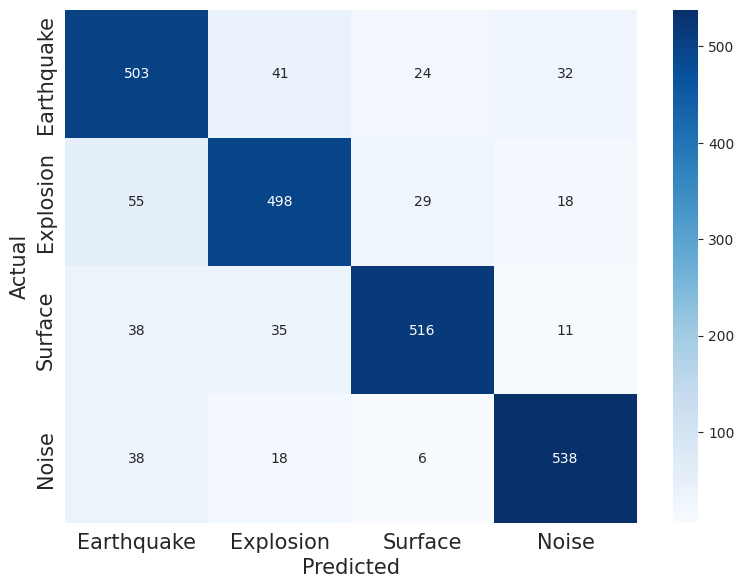

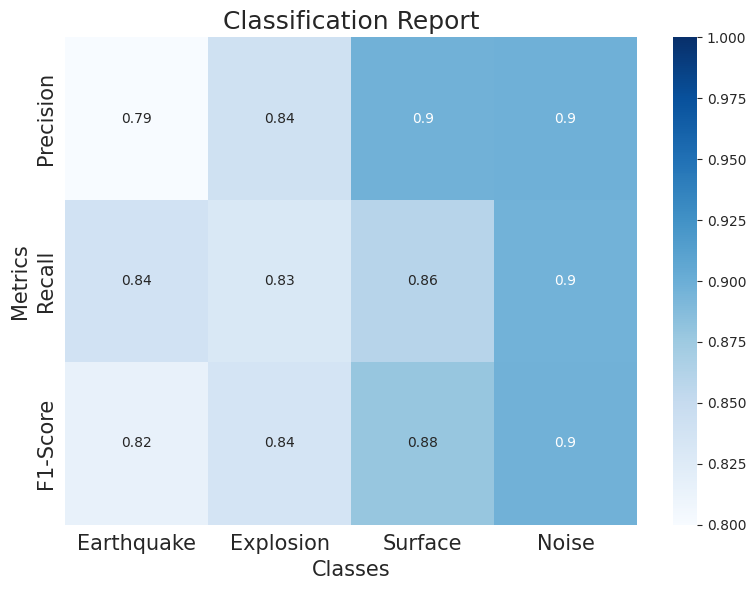

In [302]:
## plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, figure_name = '../figures/confusion_matrix_hyp_tuning_tsf_'+filename+'.png')


# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)
plot_classification_report(report, figure_name = '../figures/classification_report_hyp_tuning_tsf_'+filename+'.png')


## Preparing the training and validation (test) sets

In [303]:
## extracting metadata information for each kind of source along with features
## source_type_pnsn_label is more reliable label. 


# selecting all the earthquakes and their metadata information. 
a_eq = X_scaled[X_scaled['source'] == 'earthquake']

## removing the ambiguous events, these are the events that were assigned as earthquakes by pnsn but labelled as
## explosion in USGS ANSS catalog. 
a_eq = a_eq[a_eq['source'] != 'explosion']


## selecting all the explosions specifically px, (which is mainly quarry blasts)
a_px = X_scaled[X_scaled['source'] == 'explosion']
# removing the ambiguous events. 
a_px = a_px[a_px['source'] != 'earthquake']

a_su = X_scaled[X_scaled['source'] == 'surface event']
a_no = X_scaled[X_scaled['source'] == 'noise']



# Extract event IDs for each source type
eq_ids, px_ids, su_ids, no_ids = (
    np.unique(a['new_event_id'].values) for a in [a_eq, a_px, a_su, a_no]
)



## Specifying a random seed for the reproducibility. 
np.random.seed(123) 

## no. of traces per class in training set 
nos = 6000

## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), nos)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), nos)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), nos)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), nos)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px, train_su, train_no])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px, test_su, test_no])

# allocating event id as index
X_scaled.index = X_scaled['new_event_id'].values


# extracting training and testing values
X_train = X_scaled.loc[all_train_ids]
X_test = X_scaled.loc[all_test_ids]



Y_train = X_train['source'].values
Y_test = X_test['source'].values

## ## We can experiment by removing and adding the manual features in the cell below to see how much they contribute to performance

In [304]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.drop(['hour_of_day', 'day_of_week', 'month_of_year', 'serial_no','source','new_event_id'], axis = 1)
x_train_man = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.drop(['hour_of_day', 'day_of_week', 'month_of_year', 'serial_no','source','new_event_id'], axis = 1)
x_test_man = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



In [305]:
def compute_model_performance(x_train = x_train, x_test = x_test, holder = '_tsf_'):
    
    # initiating a random undersampler for randomly selecting nus traces from each class. 
    # note that these are going to be selected from training dataset which was already separated from testing 
    # dataset for the purpose of computing events wise performance. 
    # we have also specified a random state for reproducibility
    
    
    # number of samples per each event. 
    nus = 6000
    
    # initiating a random undersampling instance. 
    rus = RandomUnderSampler(sampling_strategy={'earthquake':nus, 'explosion':nus,'surface event':nus,'noise':nus}, random_state = 42)
    
    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()
    # Converting the textual labels into numerical labels
    y_num_test = label_encoder.fit_transform(Y_test)
    
    ## Creating the training dataset on which the model will be trained. 
    # randomly taking 5000 samples per class from the training dataset
    X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)
    
    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num_res = label_encoder.fit_transform(y_resampled)

    # No class weight since we are taking equal number of elements in each class. 
    best_model.class_weight  = None
    # fitting the model. 
    print(f'Fitting the model on {nus} randomly sampled traces per class')
    print(f'computing the models fitting time')
    
    stime = time.time()
    best_model.fit(X_resampled, y_num_res)
    etime = time.time() - stime
    
    
    
    
    print('Computing the trace wise performance on the global dataset')
    y_pred = best_model.predict(x_test)
    

    trace_cm_phy = confusion_matrix(y_num_test, y_pred)
    plot_confusion_matrix(trace_cm_phy, figure_name = '../figures/trace_conf_matrix'+holder+filename+'.png')

    # Calculate the classification report
    trace_report_phy = classification_report(y_num_test, y_pred, output_dict=True)
    plot_classification_report(trace_report_phy, figure_name = '../figures/trace_class_report'+holder+filename+'.png')
    
    
    
    
    print('Computing event wise performance')
    probs_all = best_model.predict_proba(x_test)

    X_test['labelled'] = y_num_test
    X_test['classified'] = y_pred
    X_test['eq_probability'] = probs_all[:,0]
    X_test['px_probability'] = probs_all[:,1]
    X_test['no_probability'] = probs_all[:,2]
    X_test['su_probability'] = probs_all[:,3]

    
    X_test['event_id'] = X_test['new_event_id'].str.split('_').str[0].values
    
    # computing the labels and event ids corresponding to each event.
    mean_labels = X_test.groupby('event_id').mean()['labelled'].values
    mean_ids = X_test.groupby('event_id').mean().index.values

    # computing the means probabilities of each class for a given event. 
    mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
    mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
    mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
    mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values
    
    # assigning a class based on the maximum among the mean probabilities of each class across the stations. 
    temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
    # computing the maximum mean probability
    temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)

    # computing the event wise confusion matrix. 
    cf_events_phy = confusion_matrix(mean_labels, temp_class)
    plot_confusion_matrix(cf_events_phy,  figure_name = '../figures/event_conf_matrix'+holder+filename+'.png')

    # computing the event wise classification report
    report_event_phy = classification_report(mean_labels, temp_class, output_dict=True)
    plot_classification_report(report_event_phy,  figure_name = '../figures/event_class_report'+holder+filename+'.png')

    
    

    
    print('Computing the performance on the balanced dataset')
    num_iter = 50
    trace_cm = []
    trace_cr = []

    for i in tqdm(range(num_iter)):
        # initiating a random undersampler
        rus = RandomUnderSampler(sampling_strategy={0:2000, 1:2000, 2:2000, 3: 2000})


        # randomly taking 2500 samples per class from the training dataset
        x_res_test, y_res_test = rus.fit_resample(x_test, y_num_test)
        
        # computing the result for the balanced classes. 
        y_res_pred = best_model.predict(x_res_test)

        trace_cm.append(confusion_matrix(y_res_test, y_res_pred))
        trace_cr.append(classification_report(y_res_test, y_res_pred, output_dict=True))


    conf_matrix = np.mean(trace_cm, axis = 0)
    # Flatten the confusion matrix to true labels and predicted labels
    y_true = []
    y_pred = []

    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix[i])):
            y_true.extend([i] * int(conf_matrix[i][j]))
            y_pred.extend([j] * int(conf_matrix[i][j]))

    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=['Earthquake', 'Explosion', 'Noise', 'Surface Event'], output_dict = True)
    
    conf_matrix = conf_matrix.astype('int') 
    plot_confusion_matrix(conf_matrix,  figure_name = '../figures/balanced_confusion_matrix'+holder+filename+'.png')
    plot_classification_report(report,  figure_name = '../figures/balanced_classification_report'+holder+filename+'.png')


    
    
    
    
    print('Saving results into disk')
    # Saving every result into disk

    # Saving trace results
    ## physical 
    
    # saving model training time 
    with open('../results/model_training_time'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(etime, pickle_file)

    
    # saving trace wise report
    with open('../results/trace_report'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(trace_report_phy, pickle_file)

    # saving trace wise confusion matrix
    with open('../results/trace_confusion_matrix'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(trace_cm_phy, pickle_file)



    # Saving event wise report
    with open('../results/event_report'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(report_event_phy, pickle_file)

    # Saving event wise confusion matrix
    with open('../results/event_confusion_matrix'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(cf_events_phy, pickle_file)


    # saving balanced trace wise report    
    with open('../results/balanced_trace_report'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(report, pickle_file)


    # saving balanced trace wise confusion matrix. 
    with open('../results/balanced_trace_confusion_matrix'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(conf_matrix, pickle_file)
        
        
    print('Saving trained model')
    dump(best_model, '../results/best_rf_model_all_features'+holder+filename+'.joblib')
    
    
    # saving the scaler parameters
    new_scaler_params = scaler_params
    new_scaler_params.index = new_scaler_params['Feature']

    
    print('saving the scalar params')
    new_scaler_params.to_csv('../results/scaler_params'+holder+filename+'.csv', index = False)


Fitting the model on 6000 randomly sampled traces per class
computing the models fitting time
Computing the trace wise performance on the global dataset
Computing event wise performance


  0%|          | 0/50 [00:00<?, ?it/s]

Computing the performance on the balanced dataset


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


Saving results into disk
Saving trained model
saving the scalar params


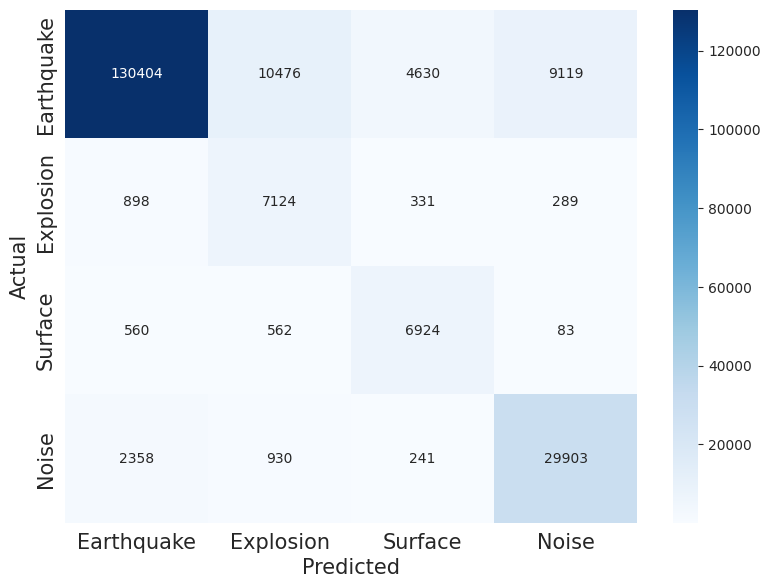

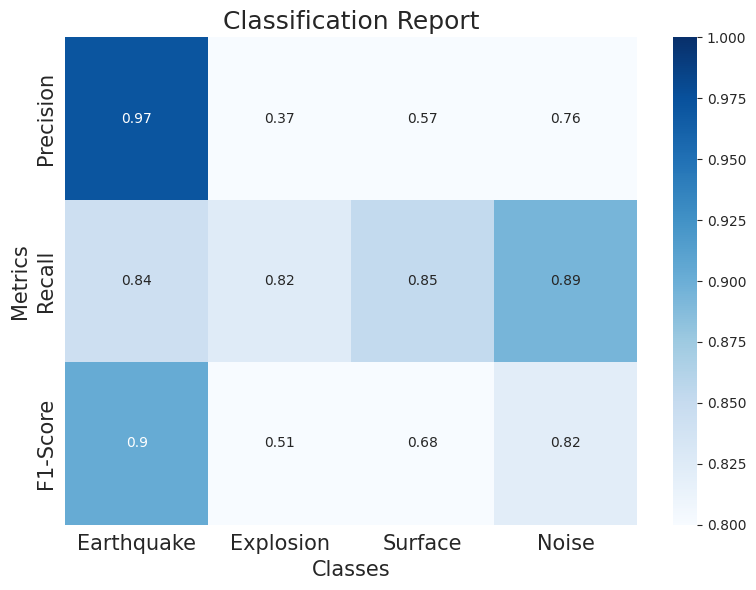

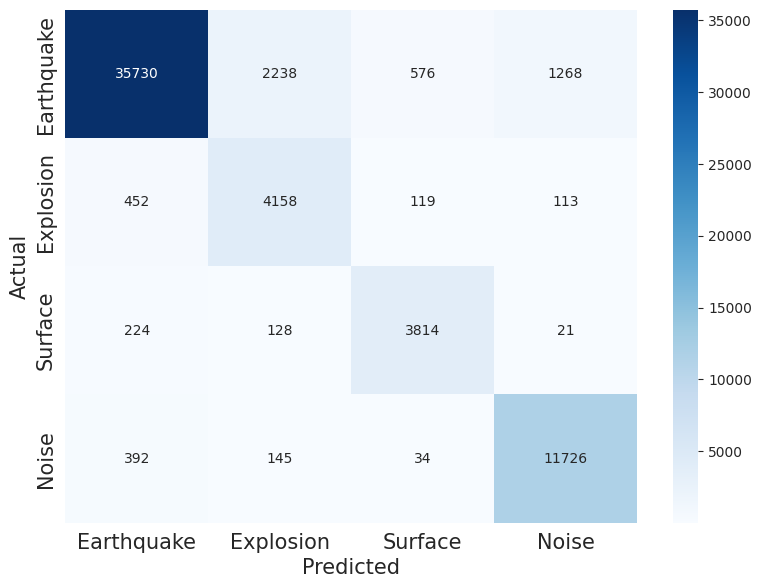

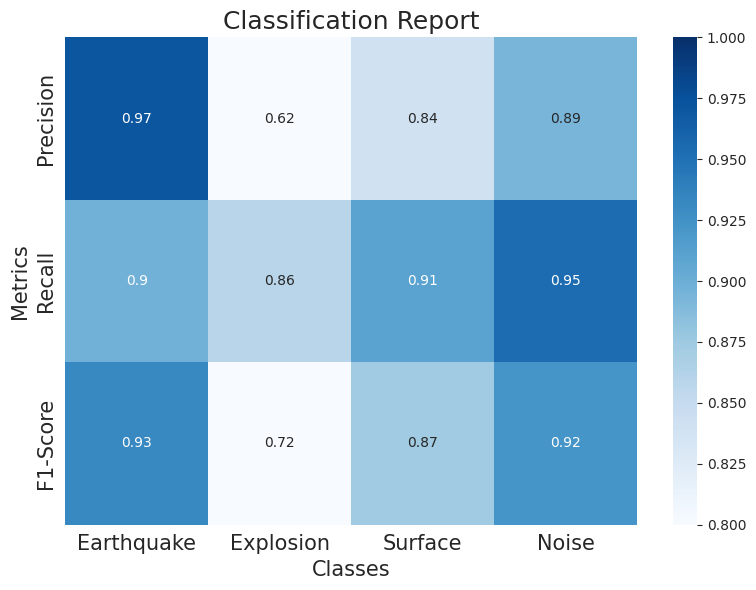

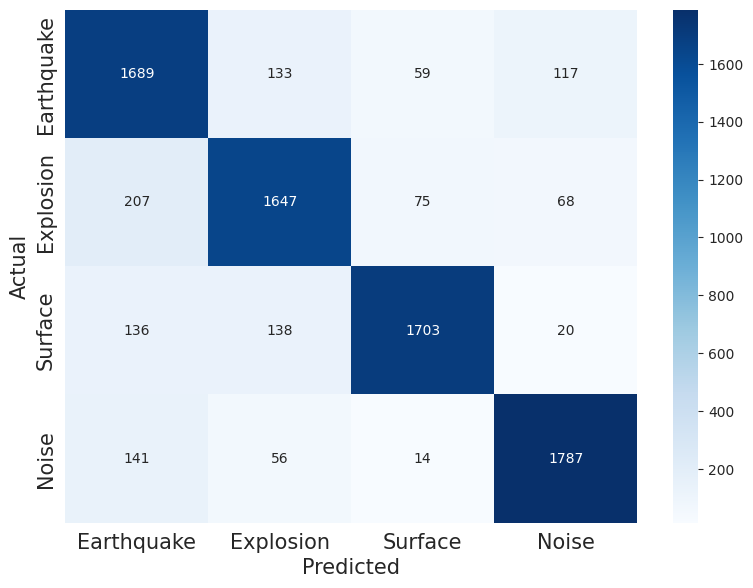

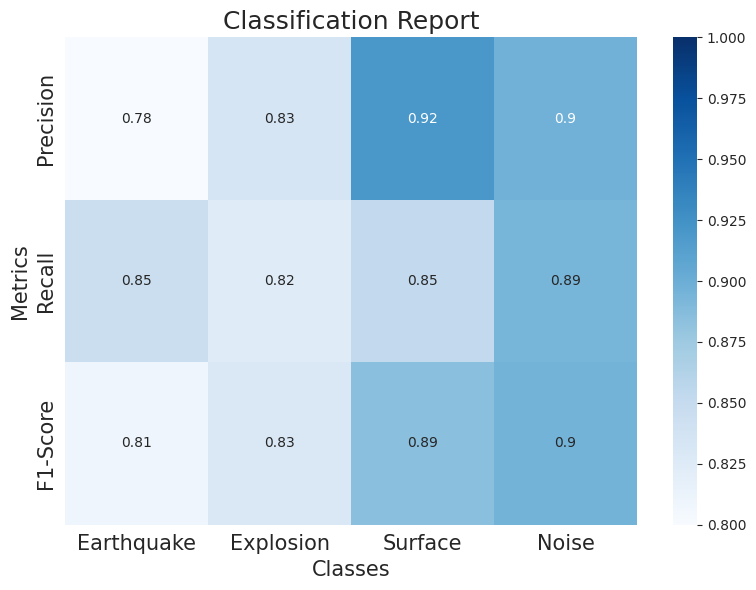

In [306]:
## computing all the results just for physcial features. 
compute_model_performance(x_train = x_train, x_test = x_test, holder = '_tsf_')

Fitting the model on 6000 randomly sampled traces per class
computing the models fitting time
Computing the trace wise performance on the global dataset
Computing event wise performance


  0%|          | 0/50 [00:00<?, ?it/s]

Computing the performance on the balanced dataset


100%|██████████| 50/50 [03:05<00:00,  3.71s/it]


Saving results into disk
Saving trained model
saving the scalar params


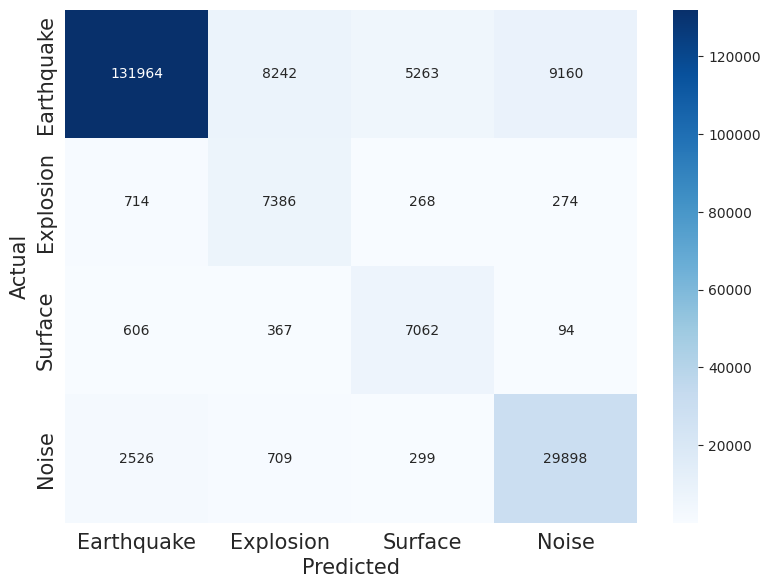

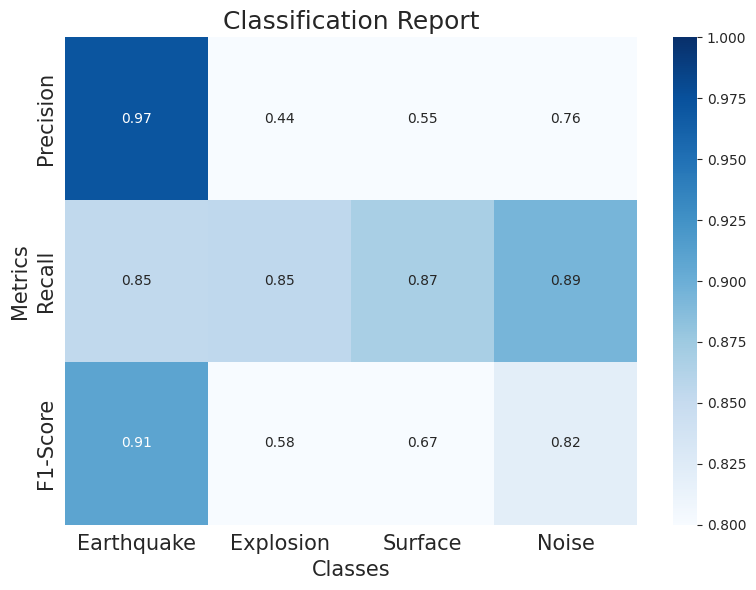

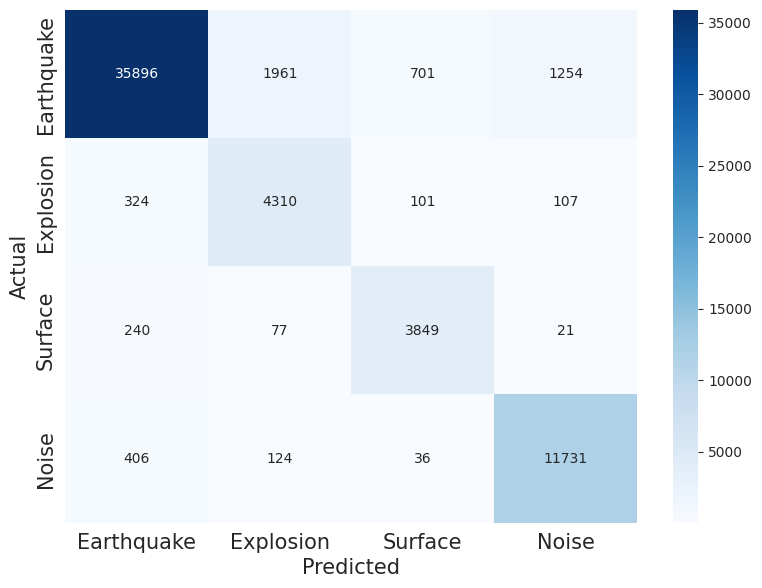

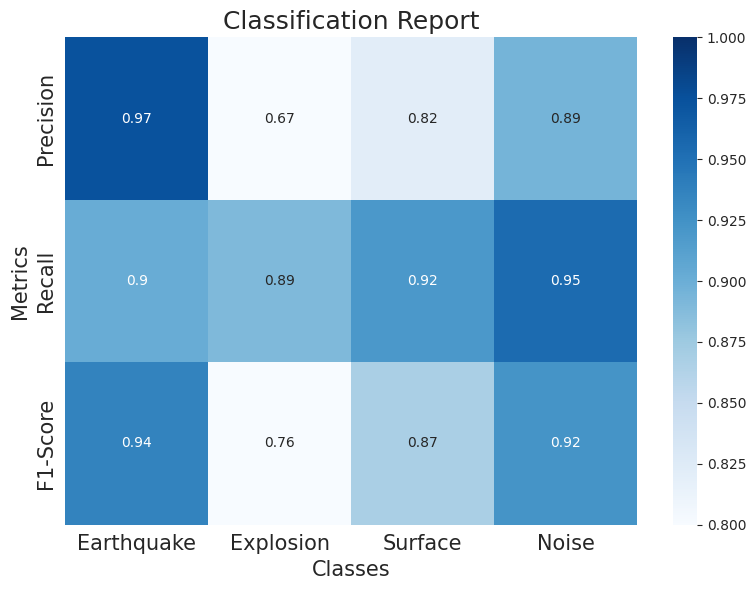

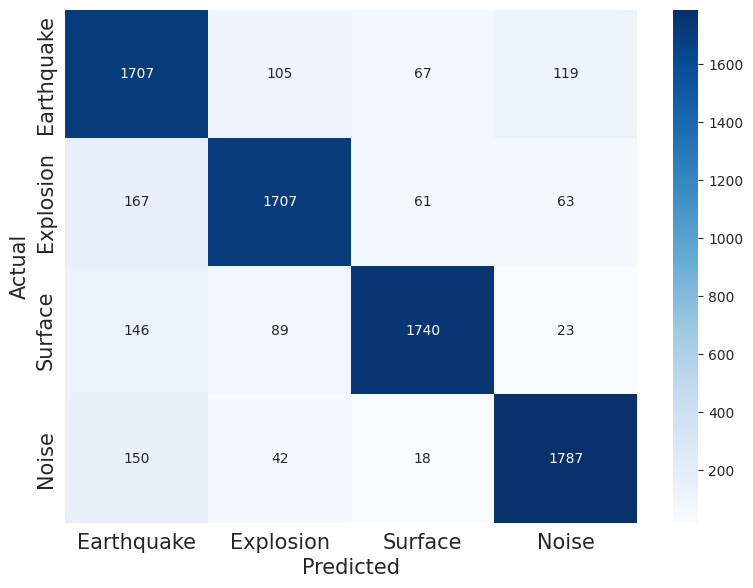

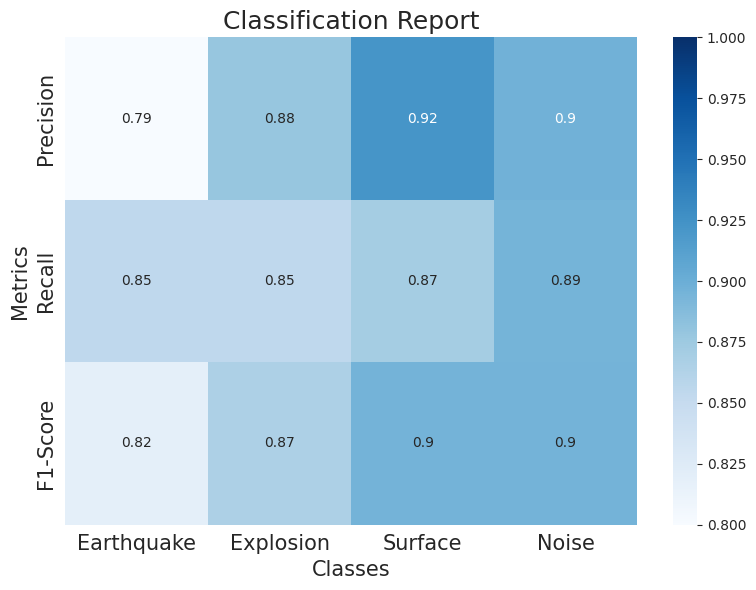

In [307]:
## computing all the results just for physcial features. 
compute_model_performance(x_train = x_train_man, x_test = x_test_man, holder = '_tsf_man_')